In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
import numpy as np
import sklearn.datasets as datasets
import hess.utils as utils

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
np.random.permutation(10)

array([0, 6, 1, 2, 9, 4, 5, 3, 8, 7])

In [4]:
X, Y = twospirals(1500, noise=1.)
perm = np.random.permutation(3000)
X = X[perm,:]
Y = Y[perm]
num_test = 1000

In [5]:
X.shape

(3000, 2)

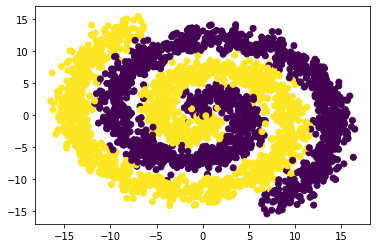

In [6]:
plt.scatter(X[:,0], X[:,1], c=Y)

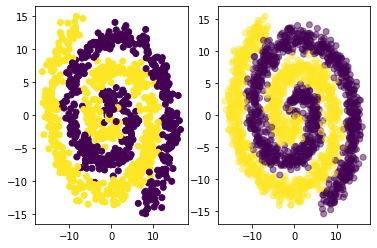

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(X[:num_test, 0], X[:num_test, 1], c=Y[:num_test])
ax[1].scatter(X[num_test:,0], X[num_test:, 1], c=Y[num_test:], alpha = 0.5)

In [8]:

train_x = torch.FloatTensor(X[:num_test])
test_x = torch.FloatTensor(X[num_test:])

train_y = torch.FloatTensor(Y[:num_test]).unsqueeze(-1)
test_y = torch.FloatTensor(Y[num_test:]).unsqueeze(-1)

In [9]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()

In [10]:
def train_model(model, train_x, train_y):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    loss_func = torch.nn.BCEWithLogitsLoss()

    losses = []

    for step in range(2000):
        optimizer.zero_grad()
        outputs = model(train_x)

        loss=loss_func(outputs, train_y)
        trainL = loss.detach().item()
        if step % 500 is 0:
            print("train loss = ", trainL)
        losses.append(trainL)
        loss.backward()
        optimizer.step()
    
    return losses

In [11]:
def get_model(hidden_size=20, n_hidden=5):
    in_dim = 2
    out_dim = 1
    model = hess.nets.SimpleNet(in_dim, out_dim, n_hidden=n_hidden, hidden_size=hidden_size,
                         activation=torch.nn.ELU(), bias=True)
    
    if use_cuda:
        model=model.cuda()
        
    return model

In [12]:
import hess.utils as utils

def get_hessian(model, train_x, train_y):
    n_par = sum(torch.numel(p) for p in model.parameters())

    hessian = torch.zeros(n_par, n_par)
    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0)
        base_vec[0, pp] = 1.

        base_vec = utils.unflatten_like(base_vec, model.parameters())
        utils.eval_hess_vec_prod(base_vec, model,
                                criterion=torch.nn.BCEWithLogitsLoss(),
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = utils.gradtensor_to_tensor(model, include_bn=True)
            hessian = torch.zeros(output.nelement(), output.nelement())
            hessian[:, pp] = output

        hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()
        
    return hessian

In [13]:
rep_full_list = []

for rep in range(5):

    eigs_list = []
    losses_list = []
    num_pars = []
    #hessian_list = []
    test_loss_list = []
    
    for i in range(1, 30):
        print('now running', i)

        model = get_model(hidden_size = i, n_hidden=3)
        n_par = sum(p.numel() for p in model.parameters())

        losses = train_model(model, train_x, train_y)

        hessian = get_hessian(model, train_x, train_y).detach()
        
        with torch.no_grad():
            test_loss = torch.nn.BCEWithLogitsLoss()(model(test_x), test_y)
            print('Test loss is :', test_loss.item())
        
        losses_list.append(losses)
        eigs_list.append(np.linalg.eig(hessian.cpu().numpy())[0])
        num_pars.append(n_par)
        #hessian_list.append(hessian)
        test_loss_list.append(test_loss.item())
        del hessian, model
        
    rep_full_list.append([losses_list, eigs_list, test_loss_list])

now running 1
train loss =  0.8150897026062012
train loss =  0.6142948269844055
train loss =  0.603926420211792
train loss =  0.6038320660591125
Test loss is : 0.6100678443908691
now running 2
train loss =  0.7117331624031067
train loss =  0.4637239873409271
train loss =  0.45381003618240356
train loss =  0.45062923431396484
Test loss is : 0.4739893674850464
now running 3
train loss =  0.6892500519752502
train loss =  0.36403387784957886
train loss =  0.2786385118961334
train loss =  0.2721026539802551
Test loss is : 0.27216556668281555
now running 4
train loss =  0.7488533854484558
train loss =  0.0789249837398529
train loss =  0.0701514482498169
train loss =  0.06822094321250916
Test loss is : 0.17040368914604187
now running 5
train loss =  0.6798359751701355
train loss =  0.038579974323511124
train loss =  0.03107638843357563
train loss =  0.028686854988336563
Test loss is : 0.1544410139322281
now running 6
train loss =  0.733697772026062
train loss =  0.03569350764155388
train loss

train loss =  0.02281114272773266
train loss =  0.014700579456984997
train loss =  0.01490944717079401
Test loss is : 0.16213910281658173
now running 17
train loss =  0.7037169337272644
train loss =  0.02365204319357872
train loss =  0.01733025722205639
train loss =  0.014525307342410088
Test loss is : 0.1365167498588562
now running 18
train loss =  0.6974745392799377
train loss =  0.019493134692311287
train loss =  0.01058208104223013
train loss =  0.00540376640856266
Test loss is : 0.23613230884075165
now running 19
train loss =  0.6963360905647278
train loss =  0.028600608929991722
train loss =  0.018036138266324997
train loss =  0.010546419769525528
Test loss is : 0.13994352519512177
now running 20
train loss =  0.7298783659934998
train loss =  0.017784232273697853
train loss =  0.016055284067988396
train loss =  0.014880115166306496
Test loss is : 0.18593278527259827
now running 21
train loss =  0.6941419243812561
train loss =  0.024379301816225052
train loss =  0.0121071385219693

train loss =  0.4587159752845764
train loss =  0.4559050500392914
Test loss is : 0.47172895073890686
now running 3
train loss =  0.7219650149345398
train loss =  0.2438962757587433
train loss =  0.20084697008132935
train loss =  0.14664225280284882
Test loss is : 0.20408283174037933
now running 4
train loss =  0.6899272799491882
train loss =  0.04939134418964386
train loss =  0.04068080335855484
train loss =  0.039022963494062424
Test loss is : 0.15993095934391022
now running 5
train loss =  0.6968953013420105
train loss =  0.033592015504837036
train loss =  0.020424291491508484
train loss =  0.01760333776473999
Test loss is : 0.175711989402771
now running 6
train loss =  0.7614742517471313
train loss =  0.025097712874412537
train loss =  0.01793242059648037
train loss =  0.01503936480730772
Test loss is : 0.19851334393024445
now running 7
train loss =  0.7015020847320557
train loss =  0.028682637959718704
train loss =  0.02599160559475422
train loss =  0.020513011142611504
Test loss i

train loss =  0.007802278734743595
Test loss is : 0.12157498300075531
now running 18
train loss =  0.6958391666412354
train loss =  0.022245759144425392
train loss =  0.011076071299612522
train loss =  0.01216395664960146
Test loss is : 0.23304858803749084
now running 19
train loss =  0.6708572506904602
train loss =  0.01640118844807148
train loss =  0.012052924372255802
train loss =  0.2068442851305008
Test loss is : 0.16156986355781555
now running 20
train loss =  0.6970645189285278
train loss =  0.023990055546164513
train loss =  0.01602736860513687
train loss =  0.010661703534424305
Test loss is : 0.1349545419216156
now running 21
train loss =  0.7012906074523926
train loss =  0.018367482349276543
train loss =  0.01104870717972517
train loss =  0.013742722570896149
Test loss is : 0.1642853319644928
now running 22
train loss =  0.7279809713363647
train loss =  0.018773352727293968
train loss =  0.017851004377007484
train loss =  0.011104792356491089
Test loss is : 0.1658562123775482

In [14]:
def eff_dim(x, s = 0.1):
    return np.sum(x / (x + s))



In [15]:
ed_list = []
fl_list = []
for losses_list, eigs_list, _ in rep_full_list:
    eff_dim_arr = np.array([eff_dim(ee, s = 50.) for ee in eigs_list])
    final_loss = [l[-1] for l in losses_list]
    
    ed_list.append(eff_dim_arr)
    fl_list.append(final_loss)
    
ed_list = np.array(ed_list)
fl_list = np.array(fl_list)
tl_list = np.array([ee[-1] for ee in rep_full_list])

/home/wesley/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5285: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5286: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5289: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5291: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]


(0, 1)

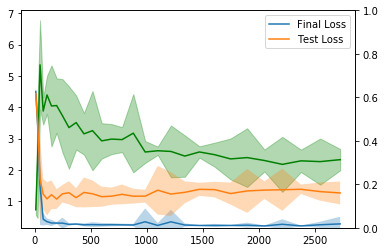

In [16]:
fig, ax = plt.subplots()

ax.plot(num_pars, ed_list.mean(0), label = 'Effective Dim', color = 'green')
ax.fill_between(num_pars, ed_list.mean(0) - 2 * ed_list.std(0), ed_list.mean(0) + 2*ed_list.std(0), alpha = 0.3,
               color='green')

ax2 = ax.twinx()
ax2.plot(num_pars, fl_list.mean(0), label = 'Final Loss')
ax2.fill_between(num_pars, fl_list.mean(0) - 2 * fl_list.std(0), fl_list.mean(0) + 2*fl_list.std(0), alpha = 0.3)

ax2.plot(num_pars, tl_list.mean(0), label = 'Test Loss')
ax2.fill_between(num_pars, tl_list.mean(0) - 2 * tl_list.std(0), tl_list.mean(0) + 2*tl_list.std(0), alpha = 0.3)

ax2.legend()
#plt.semilogy()
plt.ylim(0, 1)
#plt.vlines(train_x.shape[0], 0, 3)

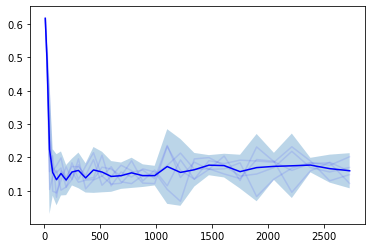

In [17]:
plt.plot(num_pars, tl_list.mean(0), label = 'Test Loss', color= 'blue')
plt.fill_between(num_pars, tl_list.mean(0) - 2 * tl_list.std(0), tl_list.mean(0) + 2*tl_list.std(0), alpha = 0.3)

plt.plot(num_pars, tl_list.T, color = 'blue', alpha = 0.1)

(0, 16)

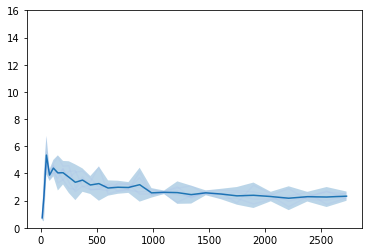

In [18]:
plt.plot(num_pars, ed_list.mean(0), label = 'Effective Dim')
plt.fill_between(num_pars, ed_list.mean(0) - 2 * ed_list.std(0), ed_list.mean(0) + 2*ed_list.std(0), alpha = 0.3)

plt.plot(num_pars, ed_list.T, color = 'blue', alpha = 0.02)
plt.ylim((0, 16))

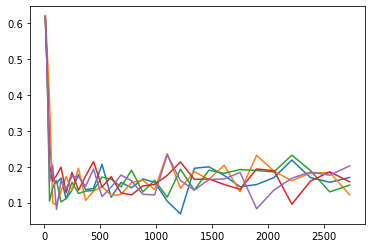

In [19]:
plt.plot(num_pars, tl_list.T)

In [20]:
import pickle

In [21]:
with open('../saved-experiments/two_spirals_descent_width.pkl', 'wb') as handle:
    pickle.dump([rep_full_list, num_pars], handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
rep_full_list